In [2]:
%reload_ext autoreload
%autoreload 2

# Load jobs and concatenated memories 

In [3]:
import cpp_soft_info

In [4]:
from result_saver import SaverProvider
provider = SaverProvider()

In [17]:
from Scratch import metadata_loader

DEVICE = "ibm_sherbrooke"
DISTANCE = int(10)
ROUNDS = str(30) 
LOGICAL = str(0)

md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md.drop(columns=["sampled_state", "num_qubits", "code",  "job_status", "optimization_level", "extra", "tags_xp", "tags"])
md = md[md["backend_name"] == DEVICE]

md = md.dropna(subset=["rounds"])

md = md[md["distance"]==DISTANCE]
# md = md[md["rounds"]==ROUNDS]
md = md[md["logical"]==LOGICAL]

# md

In [18]:
unique_rounds = md['rounds'].unique().tolist()
unique_rounds = [int(r) for r in unique_rounds]
unique_rounds.sort(reverse=True)
print(unique_rounds)

[10]


In [16]:
from tqdm import tqdm
import numpy as np

memories_by_rounds = {rounds: [] for rounds in unique_rounds}
for index, row in tqdm(md.iterrows(), total=md.shape[0], desc="Retrieving memory data"):
    job_id = row['job_id']
    rounds = int(row['rounds'])
    
    # Retrieve the job's memory data. Assuming provider.retrieve_job() is a function that does this.
    memory_data = provider.retrieve_job(job_id).result().get_memory()
    
    # Append the memory data to the corresponding list in the dictionary
    memories_by_rounds[rounds].append(memory_data)

for rounds in tqdm(memories_by_rounds, desc="Concatenating memory data"):
    if len(memories_by_rounds[rounds]) > 1:
        # Concatenate arrays along the first axis
        memories_by_rounds[rounds] = np.concatenate(memories_by_rounds[rounds], axis=0)
    elif len(memories_by_rounds[rounds]) == 1:
        # Just take the single array out of the list
        memories_by_rounds[rounds] = memories_by_rounds[rounds][0]

print(memories_by_rounds.keys())

shot_dict = {rounds: memories_by_rounds[rounds].shape[0] for rounds in memories_by_rounds}
print(shot_dict)

Retrieving memory data: 0it [00:00, ?it/s]
Concatenating memory data: 0it [00:00, ?it/s]

dict_keys([])
{}


# Initialize the code

In [8]:
import stim
import pymatching

from soft_info import get_repcode_layout, get_repcode_IQ_map
from Scratch import create_or_load_kde_grid

layout = get_repcode_layout(distance=DISTANCE, backend=provider.get_backend(DEVICE), _is_hex=True)
grid_dict, processed_scaler_dict = create_or_load_kde_grid(provider, 'cn6hk3mxhnxg008djq30', 2, 0.3, other_date=None) # rndm first sherbrooke job

# takes ~6s

In [9]:
from qiskit.result import Counts

synd_rounds = 10
memory = memories_by_rounds[synd_rounds]
print("memory shape:", memory.shape)

qubit_mapping = get_repcode_IQ_map(layout, synd_rounds)

counts = cpp_soft_info.get_counts(memory, qubit_mapping, grid_dict, processed_scaler_dict, synd_rounds)
counts = Counts(counts)

# takes 16s for 10k shots dist 40, 35 rounds 
# takes 4 s for 50k shots dist 10, 10 rounds

memory shape: (50000, 100)


# Get edge weights

In [10]:
from qiskit_qec.circuits import RepetitionCodeCircuit
from qiskit_qec.decoders import DecodingGraph

code = RepetitionCodeCircuit(DISTANCE, synd_rounds)
decoding_graph = DecodingGraph(code)

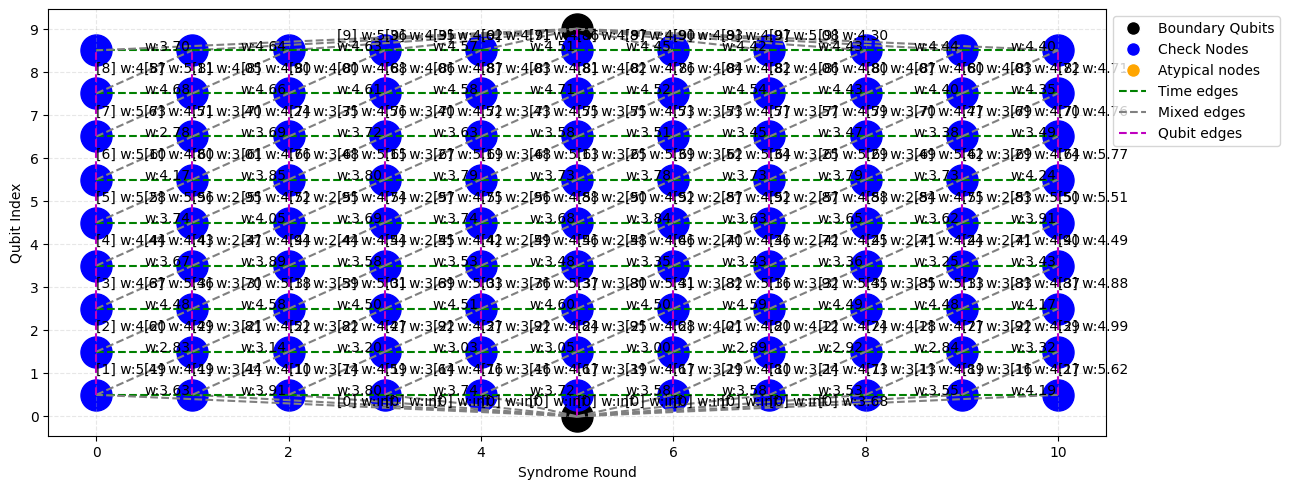

In [19]:
from soft_info import rx_draw_2D

decoding_graph.weight_syndrome_graph(counts)
rx_draw_2D(decoding_graph.graph)
# (10, 10) takes 14s

In [34]:
error_probs = decoding_graph.get_error_probs(counts, LOGICAL, method="naive")
print(error_probs)

{(0, 1): 0.026451898921235405, (1, 1): 0.0038649440885897292, (0, 0): 0.003755274261603376, (3, 4): 0.05737161056309992, (0, 4): 0.014682043444027603, (0, 3): 0.006832242845061646, (1, 4): 0.03496182856094821, (5, 6): 0.012017277509301628, (3, 6): 0.014764044943820227, (3, 5): 0.011151768600801535, (4, 6): 0.026452691718147618, (7, 8): 0.02843978763711205, (5, 8): 0.008004940734934322, (5, 7): 0.010044075266994407, (6, 8): 0.029582435281021294, (9, 10): 0.025785599698027743, (7, 10): 0.01845072129955146, (7, 9): 0.012814215236101914, (8, 10): 0.09146027435741375, (11, 12): 0.01652892561983471, (9, 12): 0.007219797567090724, (9, 11): 0.005840528186896902, (10, 12): 0.0588036498817168, (13, 14): 0.060129406514948684, (11, 14): 0.011029670046600942, (11, 13): 0.007641276027412258, (12, 14): 0.05472329716768358, (15, 16): 0.010665734143462868, (13, 16): 0.015594408778400038, (13, 15): 0.005554331055763721, (14, 16): 0.03810932657086503, (17, 18): 0.02487002652519894, (15, 18): 0.0075323827

In [35]:
# sort the values of the error_probs dict
sorted_error_probs = {k: v for k, v in sorted(error_probs.items(), key=lambda item: item[1])}
print(sorted_error_probs)

{(92, 92): 0.002337988055006483, (20, 20): 0.003434496165892645, (29, 29): 0.003691479197428994, (0, 0): 0.003755274261603376, (47, 47): 0.0037581591613371134, (1, 1): 0.0038649440885897292, (38, 38): 0.004060426126440796, (56, 56): 0.004181600955794504, (83, 83): 0.004721393256425103, (74, 74): 0.004772098831504772, (97, 98): 0.004801187202653747, (65, 65): 0.0049192315362627135, (96, 97): 0.004926736037375239, (13, 15): 0.005554331055763721, (9, 11): 0.005840528186896902, (92, 93): 0.0063936063936063945, (0, 3): 0.006832242845061646, (9, 12): 0.007219797567090724, (15, 18): 0.007532382714705562, (11, 13): 0.007641276027412258, (5, 8): 0.008004940734934322, (93, 94): 0.00840189424524802, (87, 97): 0.008565568826155145, (94, 95): 0.009169104484128717, (5, 7): 0.010044075266994407, (99, 100): 0.01008827238335435, (98, 99): 0.010505811026724156, (15, 16): 0.010665734143462868, (16, 28): 0.010807659536302076, (15, 17): 0.010847671002937475, (36, 46): 0.010993932066008374, (11, 14): 0.0110

# CProfile generate decoding graph

In [39]:
import cProfile
from qiskit_qec.circuits import RepetitionCodeCircuit
from qiskit_qec.decoders import DecodingGraph


def profile_make_syndrome_graph():
    code = RepetitionCodeCircuit(DISTANCE, synd_rounds)
    decoding_graph = DecodingGraph(code)
    decoding_graph._make_syndrome_graph()  # Directly call the function you want to profile

# Profile the function
cProfile.run('profile_make_syndrome_graph()', 'profiling_result')

# To view the profiling results
import pstats
from pstats import SortKey

p = pstats.Stats('profiling_result')
p.sort_stats(SortKey.CUMULATIVE).print_stats(10)  # Adjust the number to view more or fewer lines

Fri Dec  8 08:30:42 2023    profiling_result

         46230928 function calls (46230788 primitive calls) in 27.332 seconds

   Ordered by: cumulative time
   List reduced from 272 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   27.446   27.446 {built-in method builtins.exec}
        1    0.000    0.000   27.446   27.446 <string>:1(<module>)
        1    0.001    0.001   27.446   27.446 /var/folders/_3/n7zzdff5239886c9gmhrk6yr0000gn/T/ipykernel_30088/1671517810.py:6(profile_make_syndrome_graph)
        2    0.088    0.044   27.429   13.715 /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/libs/qiskit-qec/src/qiskit_qec/decoders/decoding_graph.py:69(_make_syndrome_graph)
        4    0.003    0.001   26.290    6.573 /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/libs/qiskit-qec/src/qiskit_qec/analysis/faultenumerator.py:238(generate_blocks)
